# 0. Imports

## 0.1. Libraries and configs

In [1]:
# Built-in
from dataclasses import dataclass
from datetime import datetime
from glob import glob
import os
from sys import path
path.append(os.path.join(".."))
from typing import Any, Dict, List, Optional

# Installed
from inflection import underscore
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import preprocessing as pp
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn import metrics as m
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, hp, tpe, fmin
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException

# Custom
from src.utils import set_jupyter_settings
set_jupyter_settings(filterwarnings=True)
from src.database.data_ingestion import ingest_data_into_database
from src.logging import logger

[03/05/23 18:12:32] INFO     Jupyter has been successfully configured.                                  ]8;id=271493;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py\utils.py]8;;\:]8;id=536110;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py#57\57]8;;\

In [2]:
# Database
CONNECTION_STRING: str | None = os.getenv("CONNECTION_STRING")

# Folder paths
DATA_DIR: str = os.path.join("..", "data")
CHECKPOINT_DIR: str = os.path.join(DATA_DIR, "interim", "cleaned_train_data.parquet")
PREPROCESSORS_DIR: str = os.path.join("..", "src", "pipeline", "preprocessors")
MODELS_DIR: str = os.path.join("..", "models")

# MLflow
MLFLOW_TRACKING_URI: str = "http://127.0.0.1:5000"
ARTIFACT_DIR: str = "models"

## 0.2. Data acquisition
Data source: [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [5]:
ingest_data_into_database(
    connection_string=CONNECTION_STRING,
    data_directory=DATA_DIR,
    files=[
        "green_tripdata_2022-01.parquet",
        "green_tripdata_2022-02.parquet",
    ]
)

[03/05/23 17:06:27] INFO     Ingesting 131894 records into the database...                     ]8;id=529202;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=146039;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#25\25]8;;\

[03/05/23 17:07:10] INFO     Data ingestion completed.                                         ]8;id=838234;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=262674;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#42\42]8;;\

In [6]:
raw_data: pd.DataFrame = pd.read_sql("SELECT * FROM green_taxi", CONNECTION_STRING)
raw_data.sample(3)

,id,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
250856,250857,2,2022-02-26 12:33:53,2022-02-26 12:49:41,N,1.0,74,239,2.0,3.29,14.0,0.0,0.5,2.63,0.0,None,0.3,20.18,1.0,1.0,2.75
253645,253646,2,2022-02-27 17:06:32,2022-02-27 17:44:45,N,1.0,24,255,1.0,9.20,31.5,0.0,0.5,4.95,0.0,None,0.3,40.00,1.0,1.0,2.75
88815,88816,1,2022-02-12 20:37:37,2022-02-12 20:44:06,N,1.0,41,42,1.0,0.90,6.0,0.5,0.5,0.00,0.0,None,0.3,7.30,2.0,1.0,0.00


# 1. Data cleansing and description

## Data dictionary
Link: [Data dictionary trip records green](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

## 1.1. Rename columns

In [7]:
raw_data.columns = [underscore(column) for column in raw_data.columns]

## 1.2. Data dimensions

In [8]:
print(
    f"""
    Number of columns: {raw_data.shape[1]}
    Number of rows: {raw_data.shape[0]:,}
    """
)


    Number of columns: 21
    Number of rows: 263,788
    


## 1.3. Duplicate data

In [9]:
raw_data.duplicated().sum()

0

## 1.4. Data types

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263788 entries, 0 to 263787
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     263788 non-null  int64         
 1   vendor_id              263788 non-null  object        
 2   lpep_pickup_datetime   263788 non-null  datetime64[ns]
 3   lpep_dropoff_datetime  263788 non-null  datetime64[ns]
 4   store_and_fwd_flag     236356 non-null  object        
 5   ratecode_id            236356 non-null  object        
 6   pu_location_id         263788 non-null  object        
 7   do_location_id         263788 non-null  object        
 8   passenger_count        236356 non-null  float64       
 9   trip_distance          263788 non-null  float64       
 10  fare_amount            263788 non-null  float64       
 11  extra                  263788 non-null  float64       
 12  mta_tax                263788 non-null  floa

## 1.5. Missing data

In [11]:
raw_data.isna().sum()

id                            0
vendor_id                     0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        27432
ratecode_id               27432
pu_location_id                0
do_location_id                0
passenger_count           27432
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                263788
improvement_surcharge         0
total_amount                  0
payment_type              27432
trip_type                 27432
congestion_surcharge      27432
dtype: int64

In [12]:
remove_rows_because_of_null_values: List[str] = [
    "store_and_fwd_flag", "passenger_count",
    "payment_type", "trip_type", "congestion_surcharge"
]
raw_data.dropna(subset=remove_rows_because_of_null_values, axis=0, inplace=True)

## 1.6. Outliers

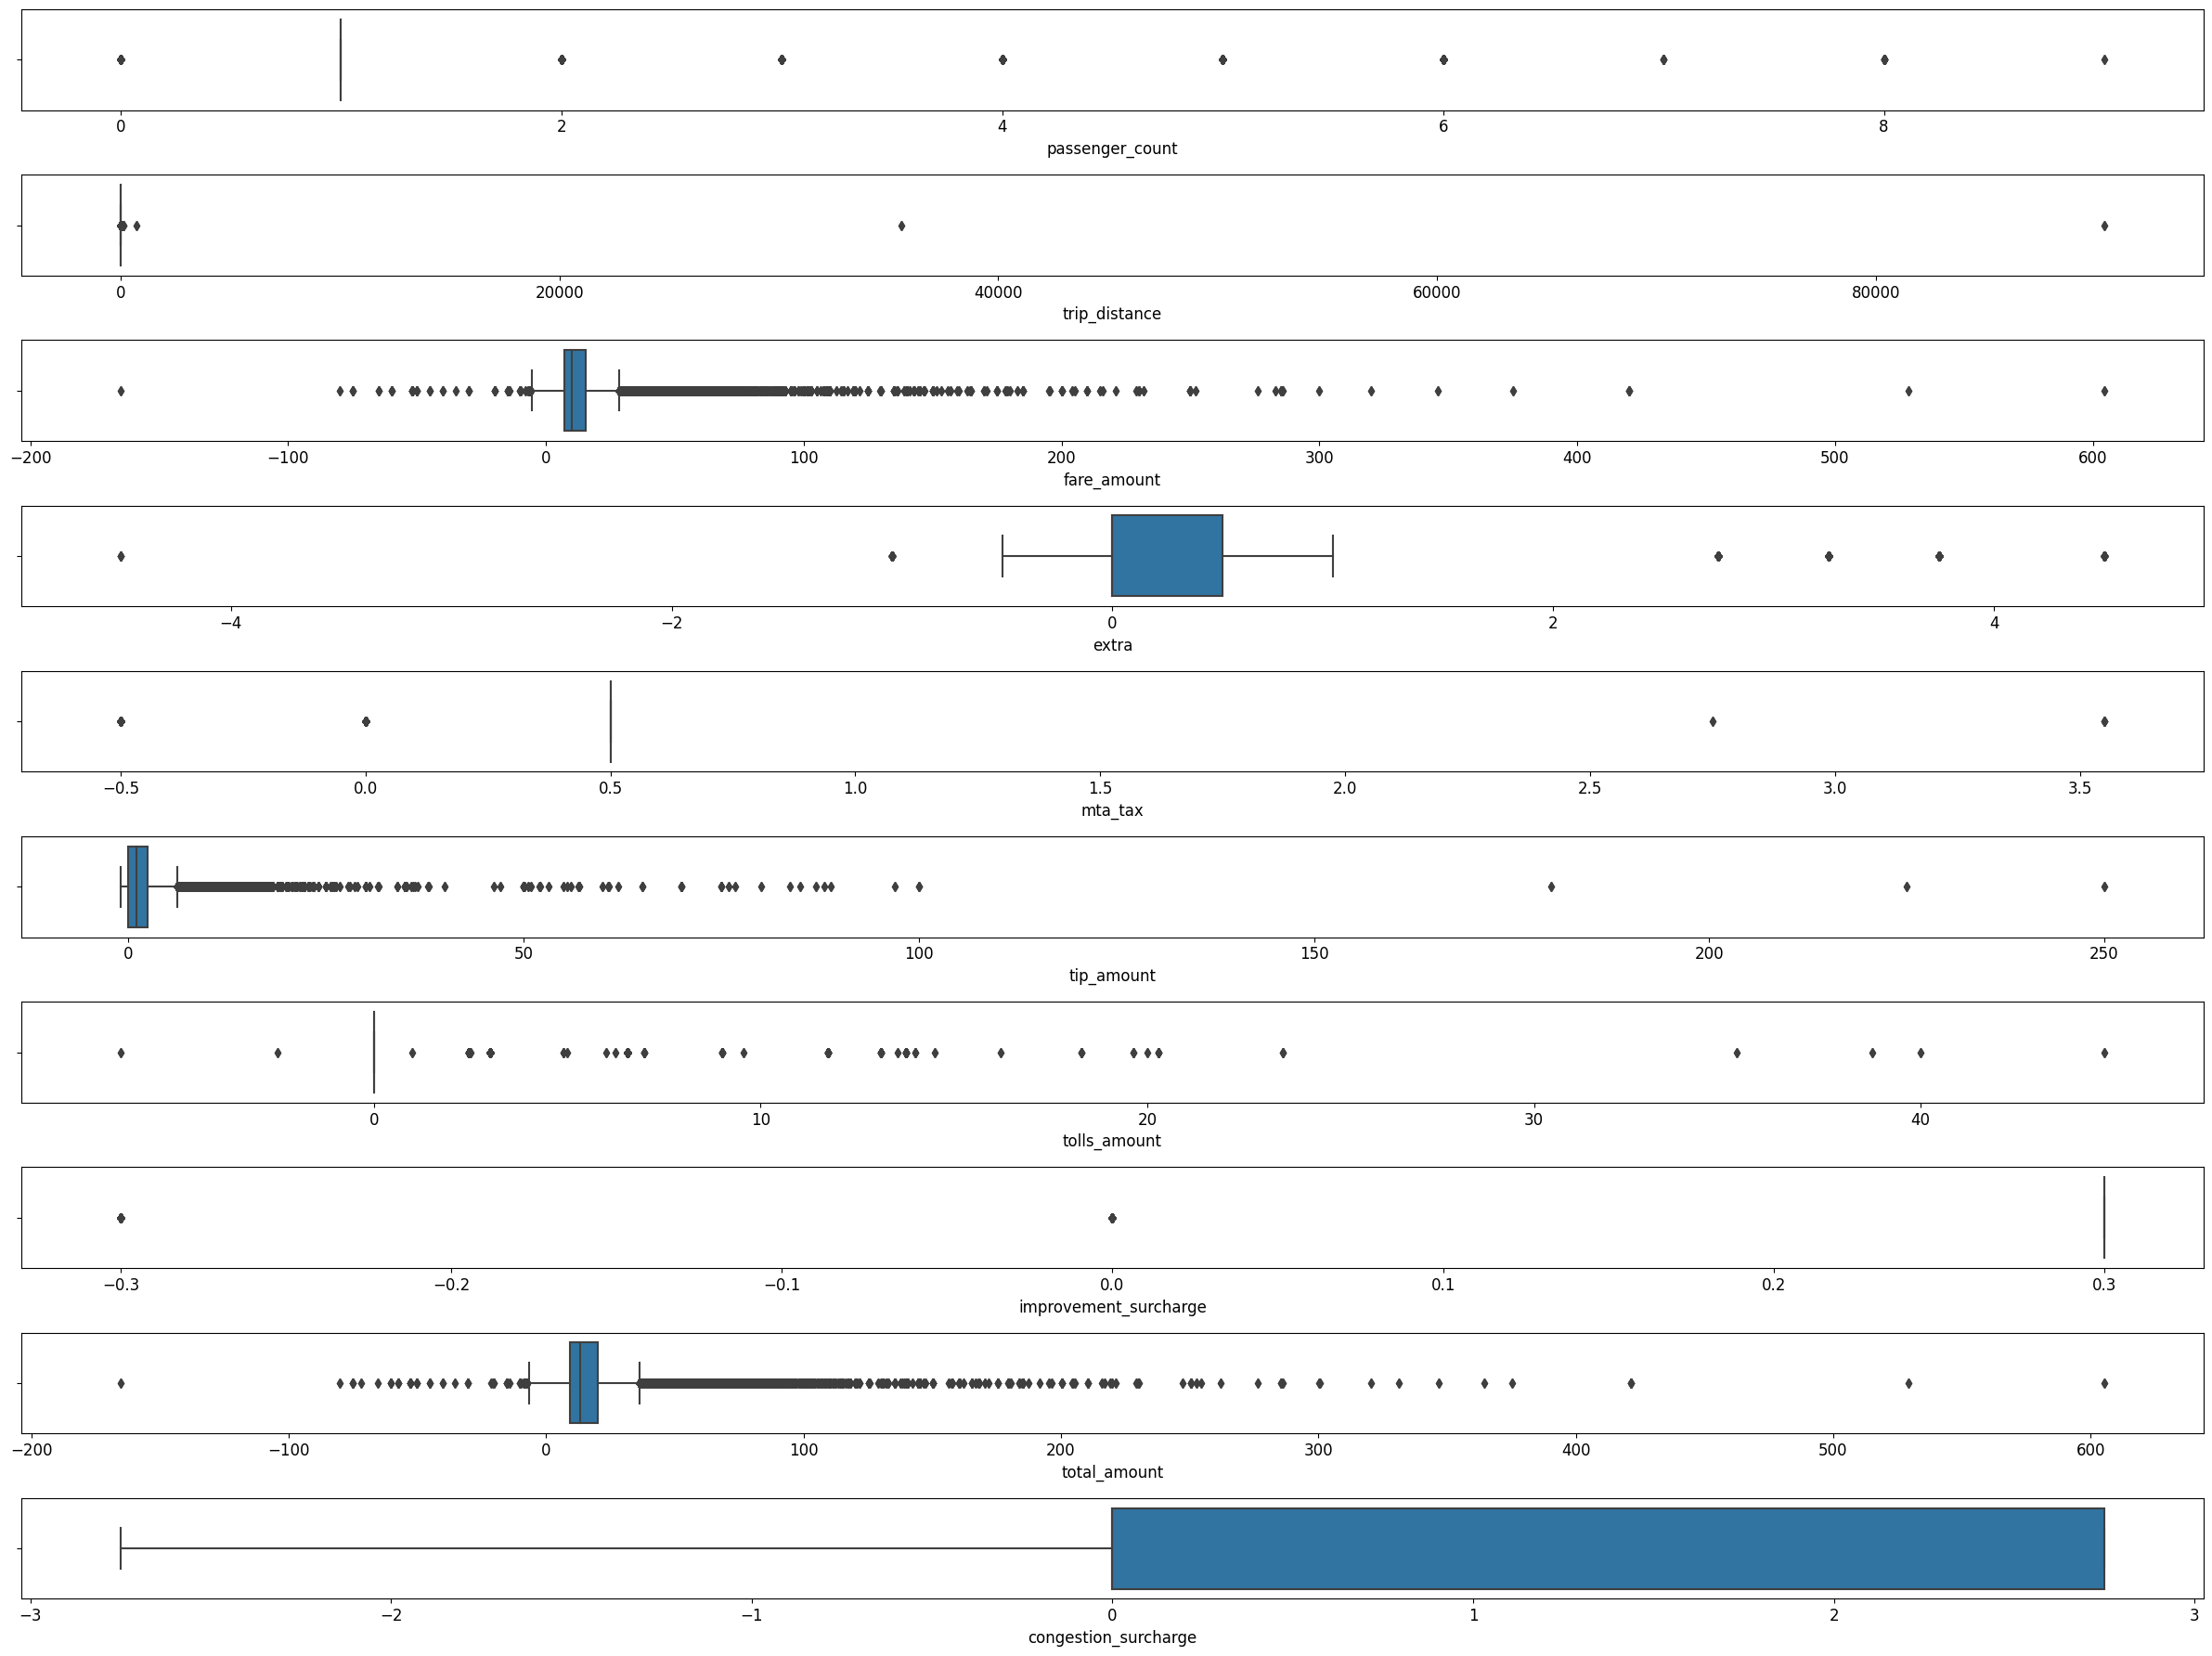

In [13]:
might_have_outlier_columns: List[str] = [
    "passenger_count", "trip_distance", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge"
]
_, ax = plt.subplots(
    nrows=len(might_have_outlier_columns),
    ncols=1,
    figsize=(24,18)
)
for idx, column in enumerate(might_have_outlier_columns):
    sns.boxplot(x=column, data=raw_data, ax=ax[idx]);
    plt.tight_layout()

In [14]:
print(f"Before: {len(raw_data):,}")
for column in might_have_outlier_columns:
    q75, q25 = np.percentile(raw_data.loc[:, column], 75), np.percentile(raw_data.loc[:, column], 25)
    iqr: float = q75 - q25
    cut_off: float = 3.0 * iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data.loc[:, column]]
    raw_data: pd.DataFrame = raw_data.loc[mask, :]
print(f"After: {len(raw_data):,}")

Before: 236,356
After: 133,906


## 1.7. Descriptive statistics

In [15]:
numerical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["int", "float"])
categorical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["object", "category"])

### 1.7.1. Numerical attributes

In [16]:
# Calculate central tendency and dispersion metrics
numerical_attributes_description = pd.DataFrame({
    "Mean": numerical_attributes.apply(np.mean),
    "Median": numerical_attributes.apply(np.median),
    "Std. deviation": numerical_attributes.apply(np.std),
    "Min": numerical_attributes.apply(np.min),
    "Max": numerical_attributes.apply(np.max),
    "Range": numerical_attributes.apply(lambda x: np.max(x) - np.min(x)),
    "Skew": numerical_attributes.apply(lambda x: x.skew()),
    "Kurtosis": numerical_attributes.apply(lambda x: x.kurtosis())
})
numerical_attributes_description

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
id,127988.573372,128183.50,7.545947e+04,1.0,256366.00,256365.00,-0.000358,-1.237885
passenger_count,1.000000,1.00,0.000000e+00,1.0,1.00,0.00,0.000000,0.000000
trip_distance,1.898339,1.46,1.574303e+00,0.0,9.67,9.67,1.879167,4.283885
fare_amount,10.081907,8.50,5.781056e+00,0.0,39.00,39.00,1.677369,3.316730
extra,0.299008,0.00,4.083383e-01,0.0,1.00,1.00,0.857917,-0.960655
mta_tax,0.500000,0.50,0.000000e+00,0.5,0.50,0.00,0.000000,0.000000
tip_amount,1.033623,0.00,1.367699e+00,0.0,9.39,9.39,1.397075,2.101779
tolls_amount,0.000000,0.00,0.000000e+00,0.0,0.00,0.00,0.000000,0.000000
improvement_surcharge,0.300000,0.30,1.110223e-16,0.3,0.30,0.00,0.000000,0.000000
total_amount,12.215091,10.56,6.101119e+00,0.8,45.36,44.56,1.469647,2.512342


### 1.7.2. Categorical attributes

In [17]:
categorical_attributes.describe().T

,count,unique,top,freq
vendor_id,133906,2,2,111608
store_and_fwd_flag,133906,2,N,132452
ratecode_id,133906,5,1.0,133624
pu_location_id,133906,197,74,23108
do_location_id,133906,231,74,10896
ehail_fee,0,0,NaN,NaN
payment_type,133906,5,1.0,74628
trip_type,133906,2,1.0,133876


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [18]:
# Create new columns using the shorthand pandas function "assign"
raw_data: pd.DataFrame = raw_data.assign(
    trip_duration=(
        raw_data.loc[:, "lpep_dropoff_datetime"] - raw_data.loc[:, "lpep_pickup_datetime"]
    ).dt.seconds / 60,
    pickup_second=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.second
    ),
    pickup_minute=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.minute
    ),
    pickup_hour=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.hour
    ),
    dropoff_second=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.second
    ),
    dropoff_minute=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.minute
    ),
    dropoff_hour=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.hour
    ),
    dropoff_day=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.day
    ),
    dropoff_week=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.week
    ),
    dropoff_weekofyear=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.weekofyear
    ),
    location_id=(
        raw_data.loc[:, "pu_location_id"] + raw_data.loc[:, "do_location_id"]
    ),
    price_per_meter=(
        raw_data.loc[:, "trip_distance"] / (raw_data.loc[:, "fare_amount"] + 0.1)
    ),
    tax_per_meter=(
        raw_data.loc[:, "trip_distance"] * raw_data.loc[:, "mta_tax"]
    ),
)

## 2.2. Filtering

In [19]:
irrelevant_columns_to_drop: List[str] = [
    "ehail_fee", "passenger_count", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge"
]
raw_data.drop(irrelevant_columns_to_drop, axis=1, inplace=True)

In [20]:
# raw_data = raw_data.loc[(raw_data.loc[:, "trip_duration"] >= 1) & (raw_data.loc[:, "trip_duration"] <= 60), :]

## Checkpoint

In [21]:
raw_data.to_parquet(CHECKPOINT_DIR)
del raw_data # Remove dirty data from memory

In [3]:
df: pd.DataFrame = pd.read_parquet(CHECKPOINT_DIR)
df.sample(3)

,id,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,payment_type,trip_type,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter
255915,255916,2,2022-02-28 18:33:54,2022-02-28 18:51:51,N,1.0,75,244,4.18,15.5,1.0,0.5,0.0,17.3,2.0,1.0,17.950000,54,33,18,51,51,18,28,9,9,75244,0.267949,2.090
114913,114914,2,2022-02-24 16:25:39,2022-02-24 16:32:04,N,1.0,75,74,1.41,7.0,1.0,0.5,0.0,8.8,2.0,1.0,6.416667,39,25,16,4,32,16,24,8,8,7574,0.198592,0.705
226034,226035,2,2022-02-15 13:30:48,2022-02-15 13:42:01,N,1.0,74,43,1.19,8.5,0.0,0.5,0.0,9.3,2.0,1.0,11.216667,48,30,13,1,42,13,15,7,7,7443,0.138372,0.595


# 3. Exploratory data analysis

## 3.1. Univariate analysis

### 3.1.1. Target variable

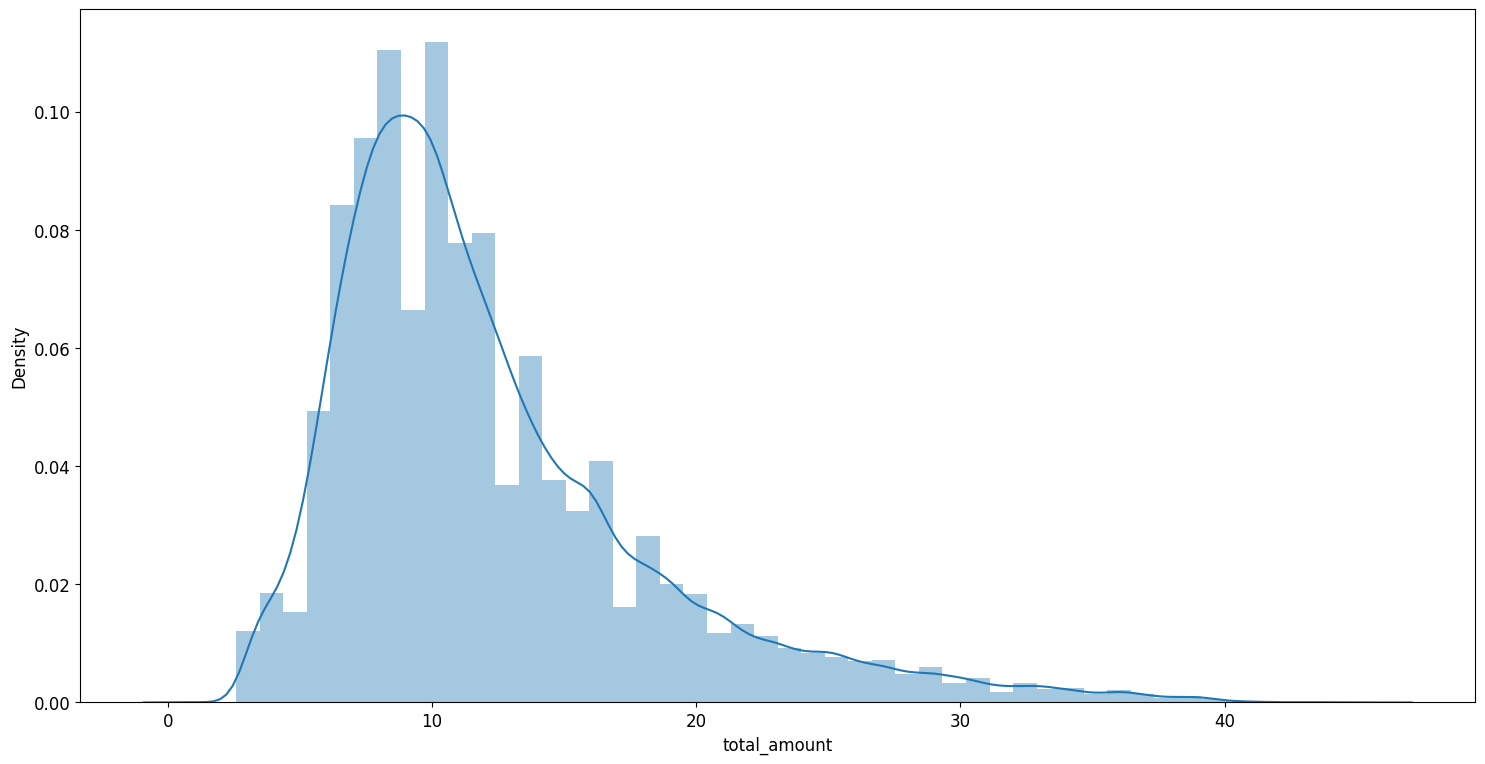

In [23]:
sns.distplot(df.loc[:, "total_amount"]);

### 3.1.2. Numerical variables

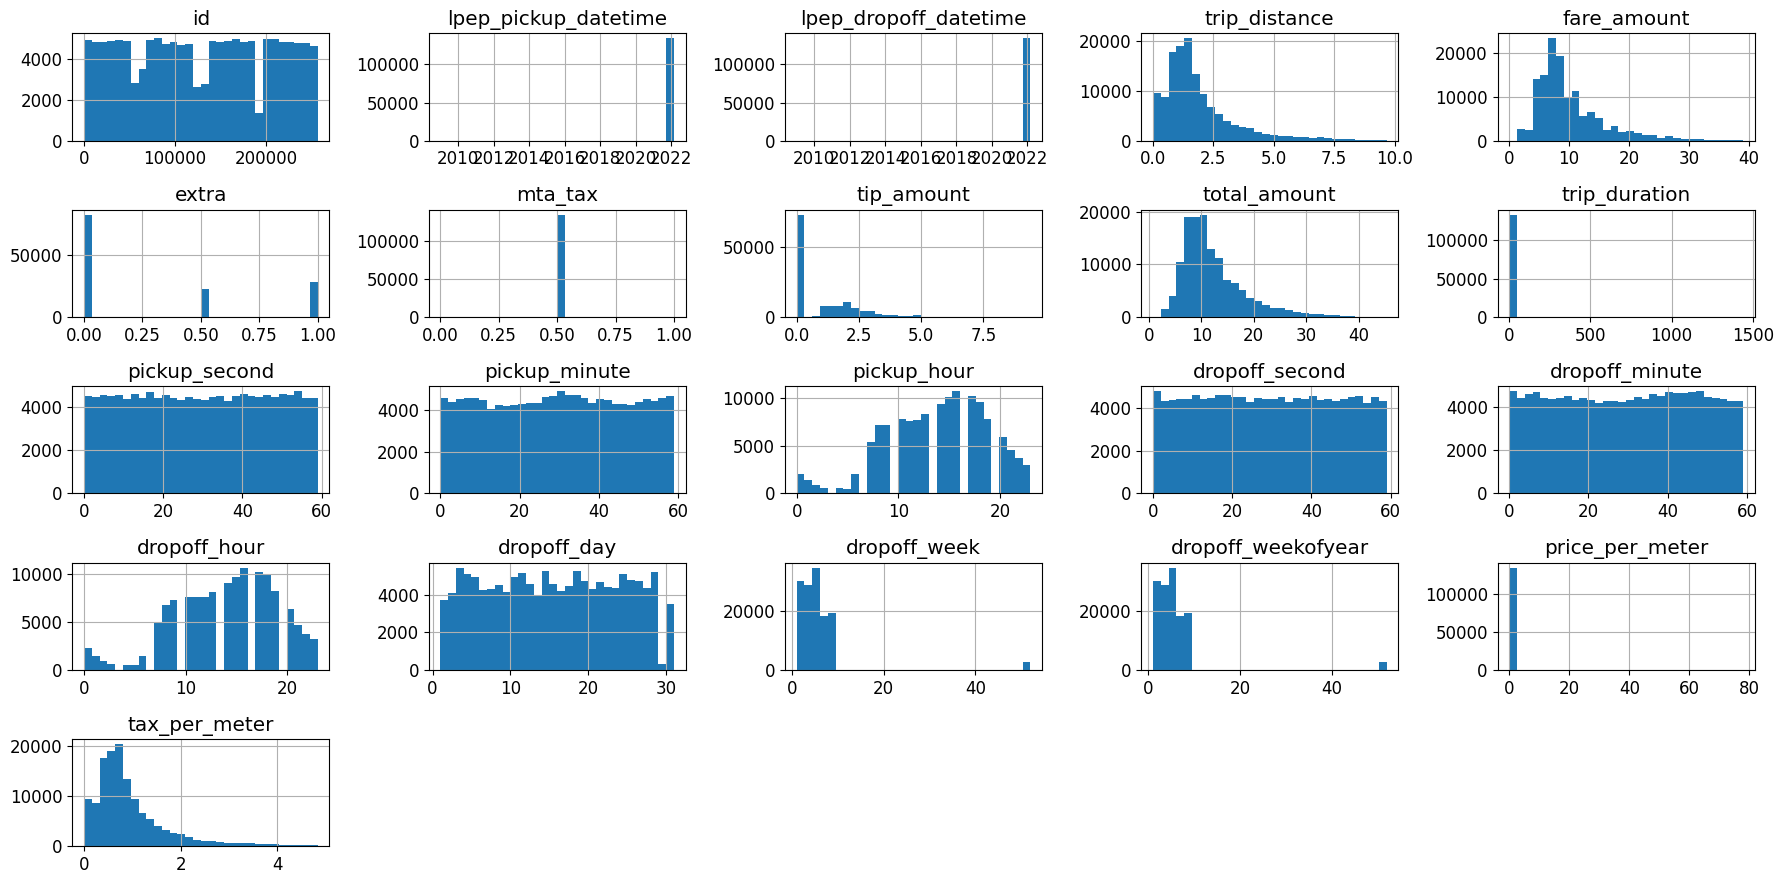

In [24]:
df.hist(bins=30);
plt.tight_layout()

### 3.1.3. Categorical variables

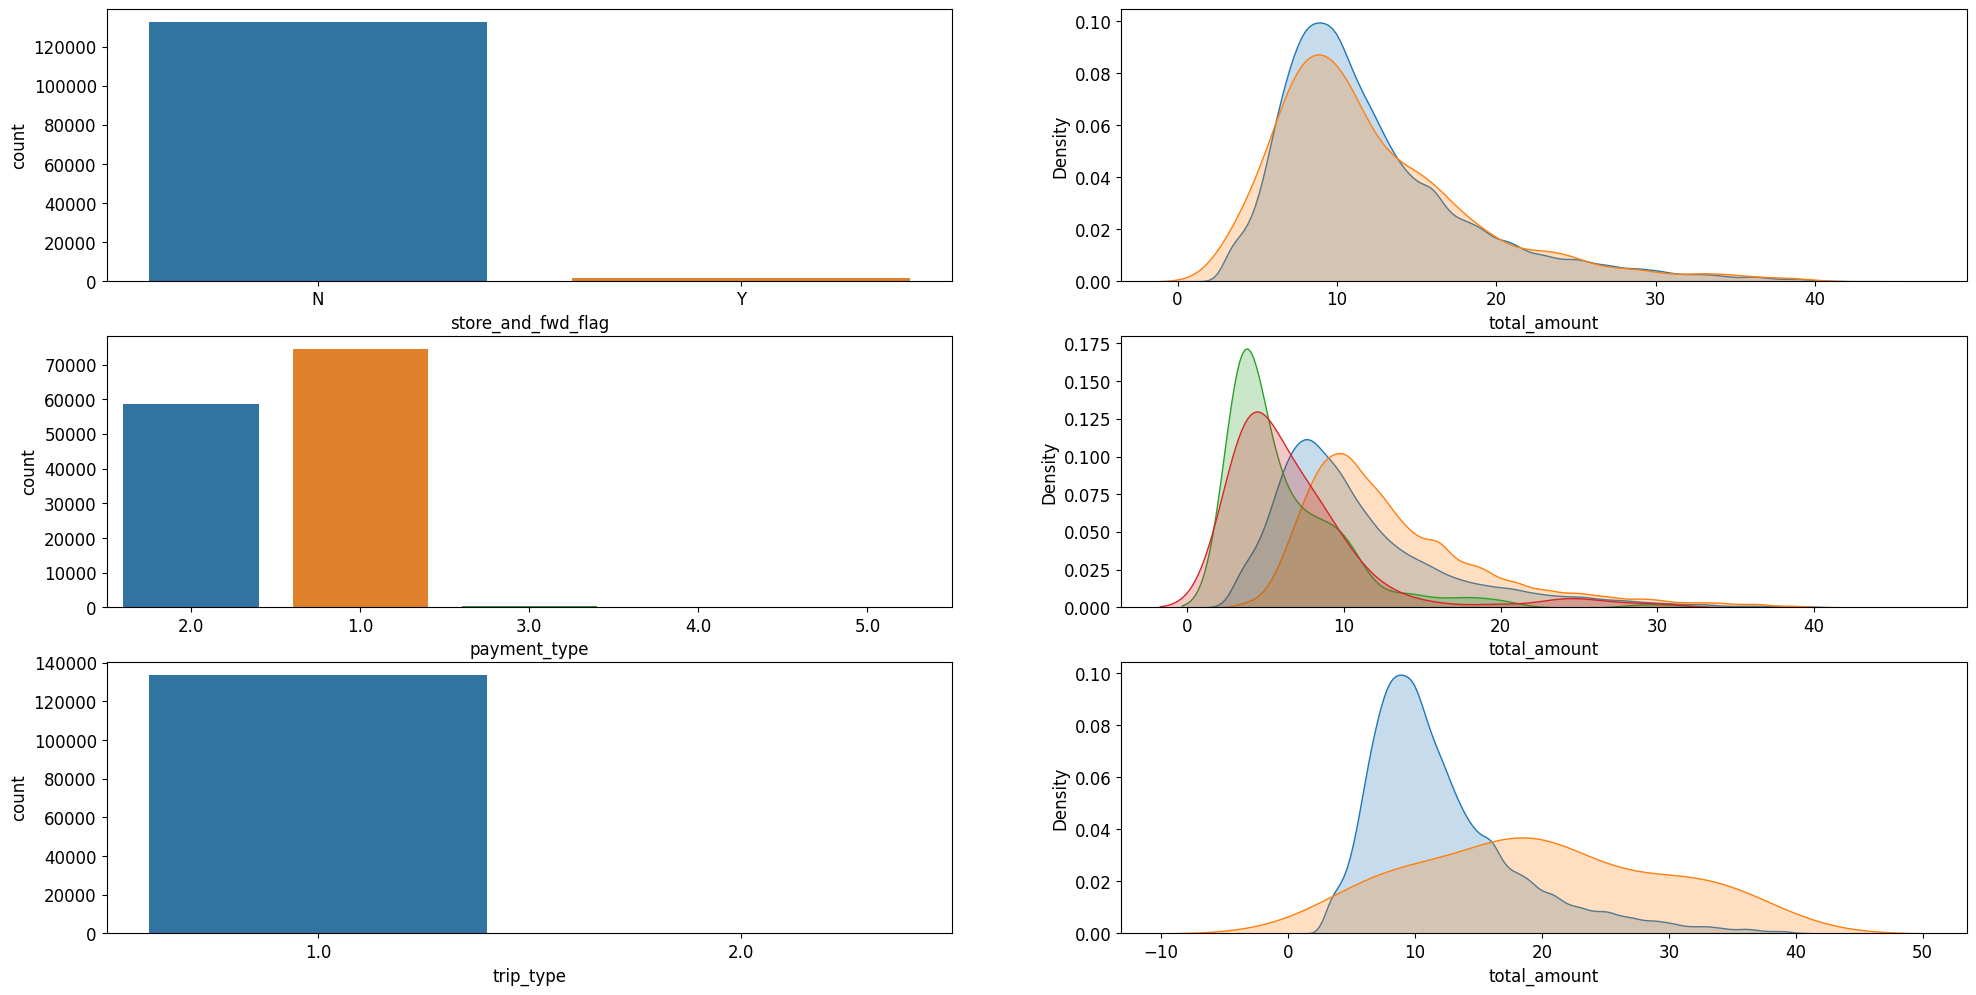

In [25]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,12))
for idx, column in enumerate(["store_and_fwd_flag", "payment_type", "trip_type"]):
    sns.countplot(x=column, data=df, ax=ax[idx][0]);
    for category in df.loc[:, column].unique():
        sns.kdeplot(
            x="total_amount",
            data=df.loc[df.loc[:, column] == category, :],
            label=category,
            shade=True,
            ax=ax[idx][1]
        );

## 3.2. Bivariate analysis

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

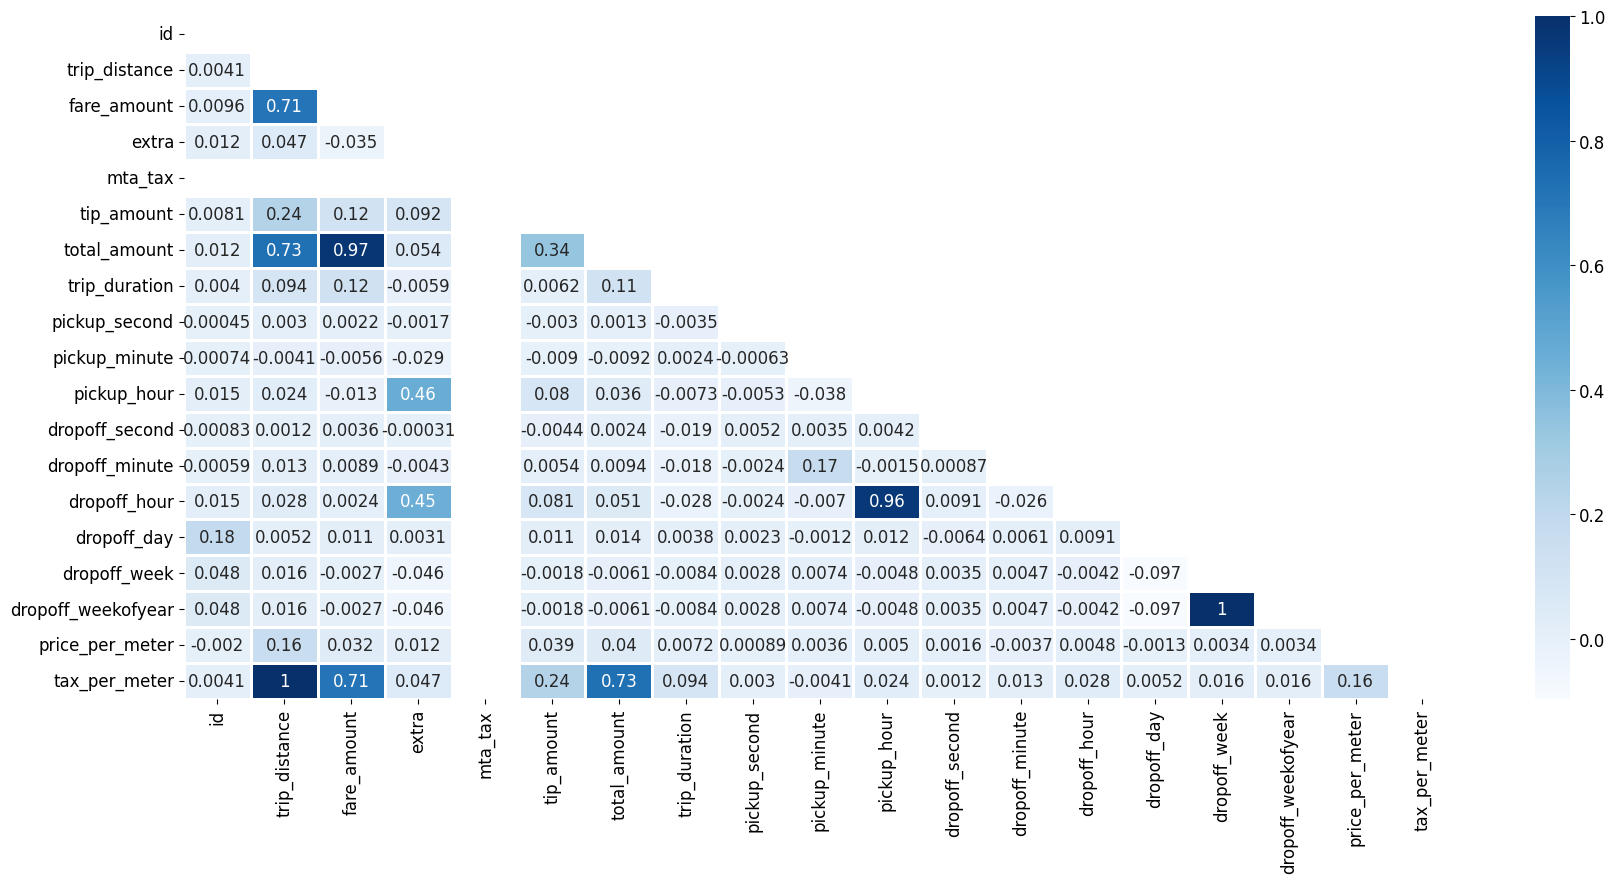

In [26]:
# Compute the correlation matrix
numerical_correlations = df.select_dtypes(include=["int", "float"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(numerical_correlations, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    numerical_correlations,
    mask=mask,
    cmap="Blues",
    annot=True,
    linewidths=2
);
plt.tight_layout()

# 4. Data preprocessing

## 4.1. Data split

In [4]:
X = df.drop("total_amount", axis=1)
y = df.loc[:, "total_amount"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
)

# Assert splited data dimensions
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## 4.2. Standardization

In [5]:
columns_to_standardize: List[str] = [
    "trip_distance", "fare_amount", "tip_amount",
    "price_per_meter", "trip_duration", "tax_per_meter",
]
for column in columns_to_standardize:
    standard_scaler = pp.StandardScaler()
    X_train.loc[:, [column]] = standard_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = standard_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        standard_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "standard_scaler",
            f"{column}.joblib"
        )
    )

## 4.3. Rescale

### 4.3.1. RobustScaler

In [6]:
columns_to_rescale: List[str] =  ["extra", "mta_tax", "tip_amount"]
for column in columns_to_rescale:
    robust_scaler = pp.RobustScaler()
    X_train.loc[:, [column]] = robust_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = robust_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        robust_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "robust_scaler",
            f"{column}.joblib"
        )
    )

## 4.4. Encoding

### 4.4.1. One-hot encoding

In [7]:
columns_to_one_hot_encode: List[str] = [
    "vendor_id",
    "store_and_fwd_flag",
    "ratecode_id",
    "payment_type",
    "trip_type",
]
X_train = pd.get_dummies(X_train, columns=columns_to_one_hot_encode, drop_first=True)
X_val = pd.get_dummies(X_val, columns=columns_to_one_hot_encode, drop_first=True)

### 4.4.2. Frequency encoding

In [8]:
columns_to_frequency_encode: List[str] = [
    "pu_location_id",
    "do_location_id",
    "location_id"
]
for column in columns_to_frequency_encode:
    column_frequency: pd.Series = X_train.groupby(column).size() / len(X_train)
    X_train.loc[:, column] = X_train.loc[:, column].map(column_frequency)
    X_val.loc[:, column] = X_val.loc[:, column].map(column_frequency)

## 4.5. Transformation

### 4.5.1. Nature transformation
References:
- [NVidia developer blog](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [Kaggle notebook](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)

In [9]:
# Create a respective sin and cosine for cyclical feature
X_train: pd.DataFrame = X_train.assign(
    pickup_second_sin=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)
X_val: pd.DataFrame = X_val.assign(
    pickup_second_sin=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)

In [10]:
# Check it out
X_train.sample(3)

,id,lpep_pickup_datetime,lpep_dropoff_datetime,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter,vendor_id_2,store_and_fwd_flag_Y,ratecode_id_2.0,ratecode_id_4.0,ratecode_id_5.0,ratecode_id_6.0,payment_type_2.0,payment_type_3.0,payment_type_4.0,payment_type_5.0,trip_type_2.0,pickup_second_sin,pickup_second_cos,pickup_minute_sin,pickup_minute_cos,pickup_hour_sin,pickup_hour_cos,dropoff_second_sin,dropoff_second_cos,dropoff_minute_sin,dropoff_minute_cos,dropoff_hour_sin,dropoff_hour_cos,dropoff_day_sin,dropoff_day_cos,dropoff_week_sin,dropoff_week_cos,dropoff_weekofyear_sin,dropoff_weekofyear_cos
140035,140036,2022-01-05 17:41:53,2022-01-05 17:53:34,0.027538,0.002222,0.483965,0.157663,2.0,0.0,0.000000,-0.059872,53,41,17,34,53,17,5,1,1,0.001876,0.208486,0.483965,1,0,0,0,0,0,0,0,0,0,0,-0.669131,0.743145,-0.913545,-0.406737,-0.965926,-0.258819,-0.406737,-0.913545,-0.669131,0.743145,-0.965926,-0.258819,0.866025,0.500000,0.781831,0.623490,0.120537,0.992709
43285,43286,2022-01-24 15:22:05,2022-01-24 15:32:55,0.046899,0.014581,-0.526607,-0.361272,0.0,0.0,0.897959,-0.070359,5,22,15,55,32,15,24,4,4,0.007029,-0.160808,-0.526607,1,0,0,0,0,0,0,0,0,0,0,0.500000,0.866025,0.743145,-0.669131,-0.707107,-0.707107,-0.500000,0.866025,-0.207912,-0.978148,-0.707107,-0.707107,-0.951057,0.309017,-0.433884,-0.900969,0.464723,0.885456
206704,206705,2022-02-06 16:18:27,2022-02-06 16:25:40,0.032980,0.014002,-0.672790,-0.620740,0.0,0.0,0.744898,-0.114978,27,18,16,40,25,16,6,5,5,0.002959,-0.177380,-0.672790,1,0,0,0,0,0,0,0,0,0,0,0.309017,-0.951057,0.951057,-0.309017,-0.866025,-0.500000,-0.866025,-0.500000,0.500000,-0.866025,-0.866025,-0.500000,0.951057,0.309017,-0.974928,-0.222521,0.568065,0.822984


# 5. Feature selection

In [11]:
columns_derivated_to_drop: List[str] = [
    "lpep_pickup_datetime", "lpep_dropoff_datetime",
    "pickup_second", "pickup_minute", "pickup_hour",
    "dropoff_second", "dropoff_minute", "dropoff_hour",
    "dropoff_day", "dropoff_week", "dropoff_weekofyear"
]
X_train.drop(columns_derivated_to_drop, axis=1, inplace=True)
X_val.drop(columns_derivated_to_drop, axis=1, inplace=True)

In [35]:
# Regressor that will be used in both feature selection techniques
xtrees_classifier = ExtraTreesRegressor()
xtrees_classifier.fit(
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
)

ExtraTreesRegressor()

## 5.1. Feature importance

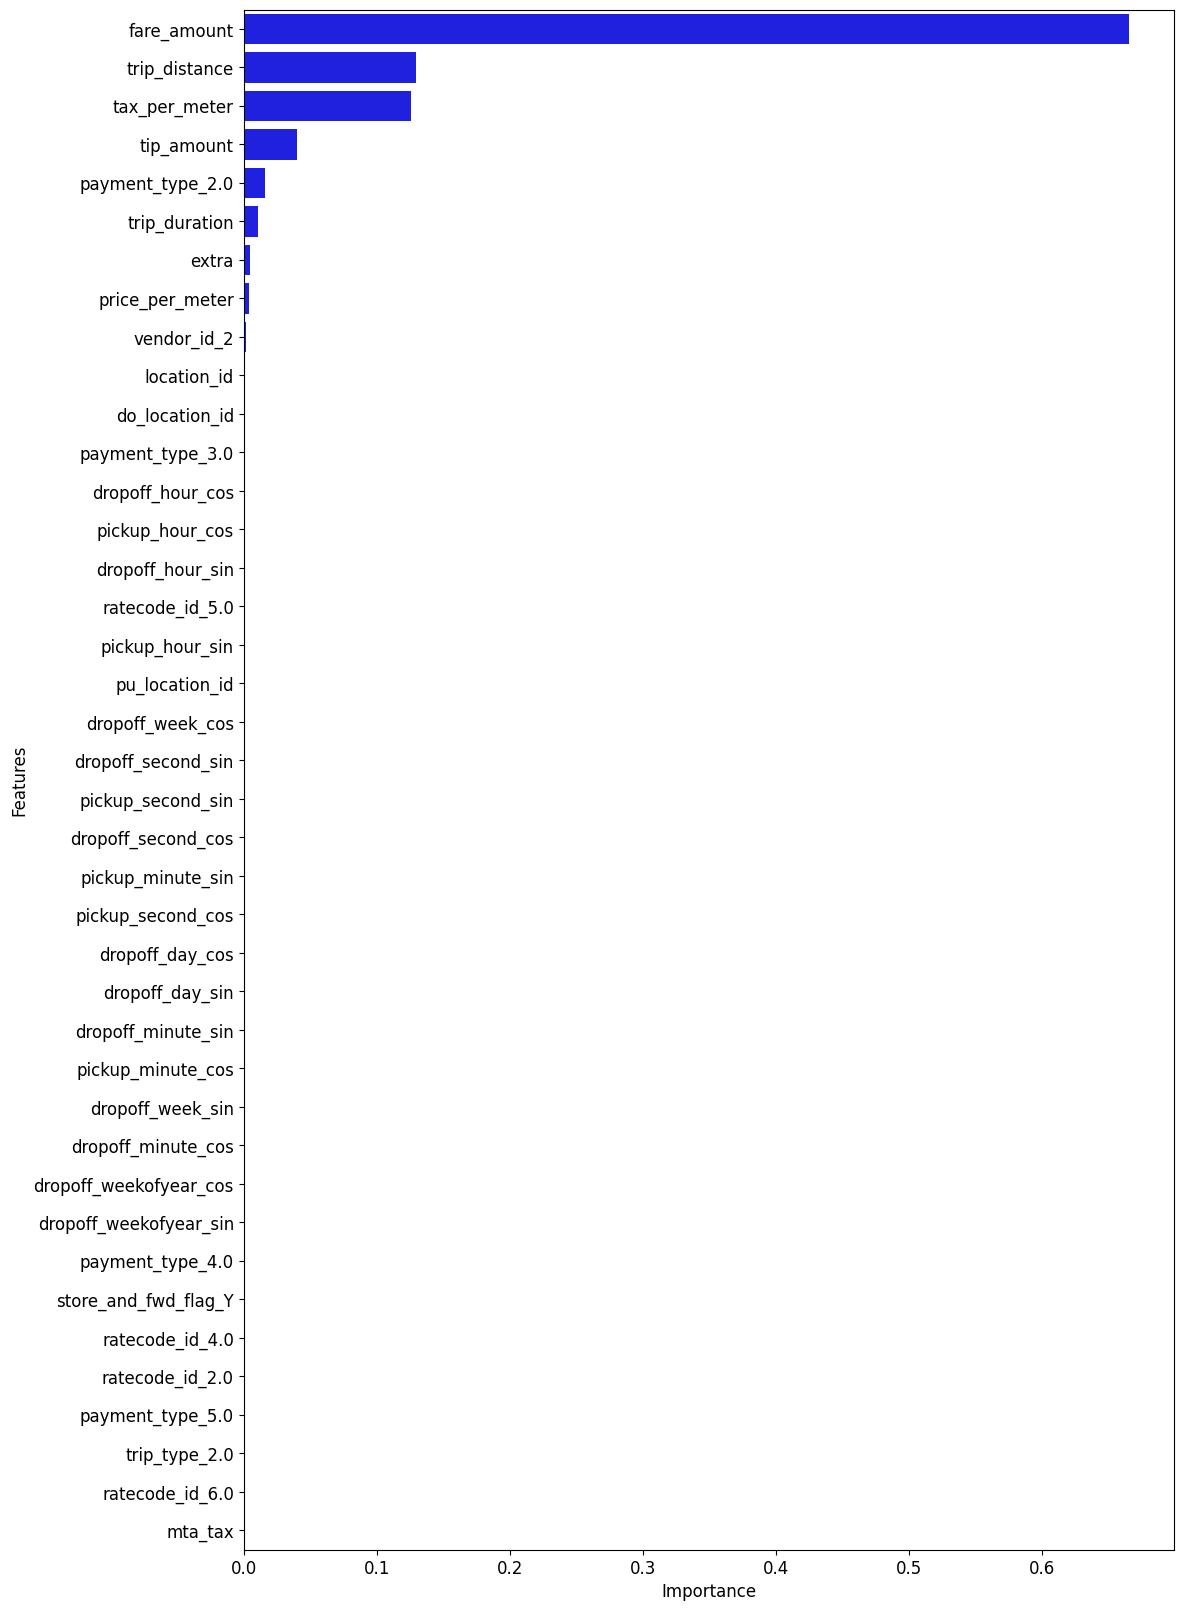

In [37]:
# Store feature importance into a dataframe and plot it
df_feature_importance = pd.DataFrame({
    "Features": X_train.drop("id", axis=1).columns,
    "Importance": xtrees_classifier.feature_importances_
}).sort_values(by="Importance", ascending=False) \
  .reset_index(drop=True)
plt.figure(figsize=(12,20))
sns.barplot(
    x="Importance",
    y="Features",
    data=df_feature_importance,
    orient="h",
    color='blue'
);

## 5.2. Wrapper

In [40]:
# Wrapper methods are usually highly computationally expensive.
# For this reason, I'm using using very low numbers for estimators and iterations
borutapy = BorutaPy(
    estimator=xtrees_classifier,
    n_estimators=10,
    max_iter=10,
    verbose=1
).fit(X_train.drop("id", axis=1).to_numpy(), y_train.to_numpy())

Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	30
Tentative: 	2
Rejected: 	6


In [41]:
boruta_best_features: List[bool] = borutapy.support_.tolist()
selected_columns_by_boruta: List[str] = [
    column for column, is_selected, rank
    in zip(X_train.columns, boruta_best_features, borutapy.ranking_)
    if is_selected and rank == 1
]
print(selected_columns_by_boruta)

['id', 'pu_location_id', 'do_location_id', 'trip_distance', 'fare_amount', 'mta_tax', 'tip_amount', 'trip_duration', 'location_id', 'price_per_meter', 'tax_per_meter', 'ratecode_id_6.0', 'trip_type_2.0', 'pickup_second_sin', 'pickup_second_cos', 'pickup_minute_sin', 'pickup_minute_cos', 'pickup_hour_sin', 'pickup_hour_cos', 'dropoff_second_sin', 'dropoff_second_cos', 'dropoff_minute_sin', 'dropoff_minute_cos', 'dropoff_hour_sin', 'dropoff_hour_cos', 'dropoff_day_sin', 'dropoff_day_cos', 'dropoff_week_sin', 'dropoff_week_cos', 'dropoff_weekofyear_sin']


## 5.3. Select columns

In [12]:
selected_columns: List[str] = [
    "id", "fare_amount", "trip_distance", "tax_per_meter",
    "trip_duration", "extra", "tip_amount", "payment_type_2.0"
]
X_train = X_train.loc[:, selected_columns]
X_val = X_val.loc[:, selected_columns]
X_train.sample(3)

,id,fare_amount,trip_distance,tax_per_meter,trip_duration,extra,tip_amount,payment_type_2.0
172127,172128,0.330641,0.286935,0.286935,0.012917,0.0,0.000000,1
4593,4594,-0.447761,-0.272375,-0.272375,-0.108810,1.0,0.510204,0
242898,242899,-0.447761,-0.335933,-0.335933,-0.093182,1.0,0.000000,1


# 6. Machine learning modeling

In [13]:
def get_metrics(scores: Dict[str, np.ndarray]) -> Dict[str, str]:
    """Convert responses from the scikit-learn model seletion function
        `cross_validate` to human-readable metrics.
    Args:
        scores (dict[str, np.ndarray]): Dictionary containing the metrics
            scores for each iteration over the model.
    """
    return {
        "MAE": np.round(np.abs(np.mean(scores["test_neg_mean_absolute_error"])), 6),
        "RMSE": np.round(np.abs(np.mean(scores["test_neg_root_mean_squared_error"])), 6),
        "MAPE": np.round(np.abs(np.mean(scores["test_neg_mean_absolute_percentage_error"])), 6)
    }

## 6.1. Baseline

In [19]:
scores_dummy: List[float] = cross_validate(
    DummyRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time dummy_results: Dict[str, float] = get_metrics(scores_dummy)
print(dummy_results)            

CPU times: user 163 µs, sys: 94 µs, total: 257 µs
Wall time: 822 µs
{'MAE': 4.574889, 'RMSE': 6.101155, 'MAPE': 0.448825}


## 6.2. Linear regression

In [20]:
scores_lr: List[float] = cross_validate(
    LinearRegression(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time lr_results: Dict[str, float] = get_metrics(scores_lr)
print(lr_results)

CPU times: user 262 µs, sys: 153 µs, total: 415 µs
Wall time: 423 µs
{'MAE': 0.001153, 'RMSE': 0.030565, 'MAPE': 8.2e-05}


## 6.3. KNeighborsRegressor

In [25]:
scores_knn: List[float] = cross_validate(
    KNeighborsRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time knn_results: Dict[str, float] = get_metrics(scores_knn)
print(knn_results)

CPU times: user 179 µs, sys: 105 µs, total: 284 µs
Wall time: 291 µs
{'MAE': 0.052129, 'RMSE': 0.216525, 'MAPE': 0.003286}


## 6.4. HistGradientBoostingRegressor

In [26]:
scores_hgb: List[float] = cross_validate(
    HistGradientBoostingRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time hgb_results: Dict[str, float] = get_metrics(scores_hgb)
print(hgb_results)

CPU times: user 160 µs, sys: 93 µs, total: 253 µs
Wall time: 259 µs
{'MAE': 0.041221, 'RMSE': 0.086278, 'MAPE': 0.003452}


## 6.5. LightGBMRegressor

In [27]:
scores_lgbm: List[float] = cross_validate(
    LGBMRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time lgbm_results: Dict[str, float] = get_metrics(scores_lgbm)
print(lgbm_results)

CPU times: user 186 µs, sys: 0 ns, total: 186 µs
Wall time: 193 µs
{'MAE': 0.038075, 'RMSE': 0.075104, 'MAPE': 0.003237}


## 6.6. XGBoostRegressor

In [28]:
scores_xgb: List[float] = cross_validate(
    XGBRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time xgb_results: Dict[str, float] = get_metrics(scores_xgb)
print(xgb_results)

CPU times: user 427 µs, sys: 256 µs, total: 683 µs
Wall time: 918 µs
{'MAE': 0.021515, 'RMSE': 0.050087, 'MAPE': 0.001804}


## 6.7. Compare models

In [29]:
df_model_comparison = pd.DataFrame(
    data=[
        dummy_results, lr_results,
        knn_results, hgb_results,
        lgbm_results, xgb_results
    ],
    columns=["MAE", "RMSE", "MAPE"],
    index=[
        "DummyRegressor",
        "LinearRegression",
        "KNeighborsRegressor",
        "HistGradientBoostingRegressor",
        "LightGBMRegressor",
        "XGBoostRegressor",
    ]
).sort_values(by="RMSE", ascending=True)
df_model_comparison

,MAE,RMSE,MAPE
LinearRegression,0.001153,0.030565,0.000082
XGBoostRegressor,0.021515,0.050087,0.001804
LightGBMRegressor,0.038075,0.075104,0.003237
HistGradientBoostingRegressor,0.041221,0.086278,0.003452
KNeighborsRegressor,0.052129,0.216525,0.003286
DummyRegressor,4.574889,6.101155,0.448825


<Axes: >

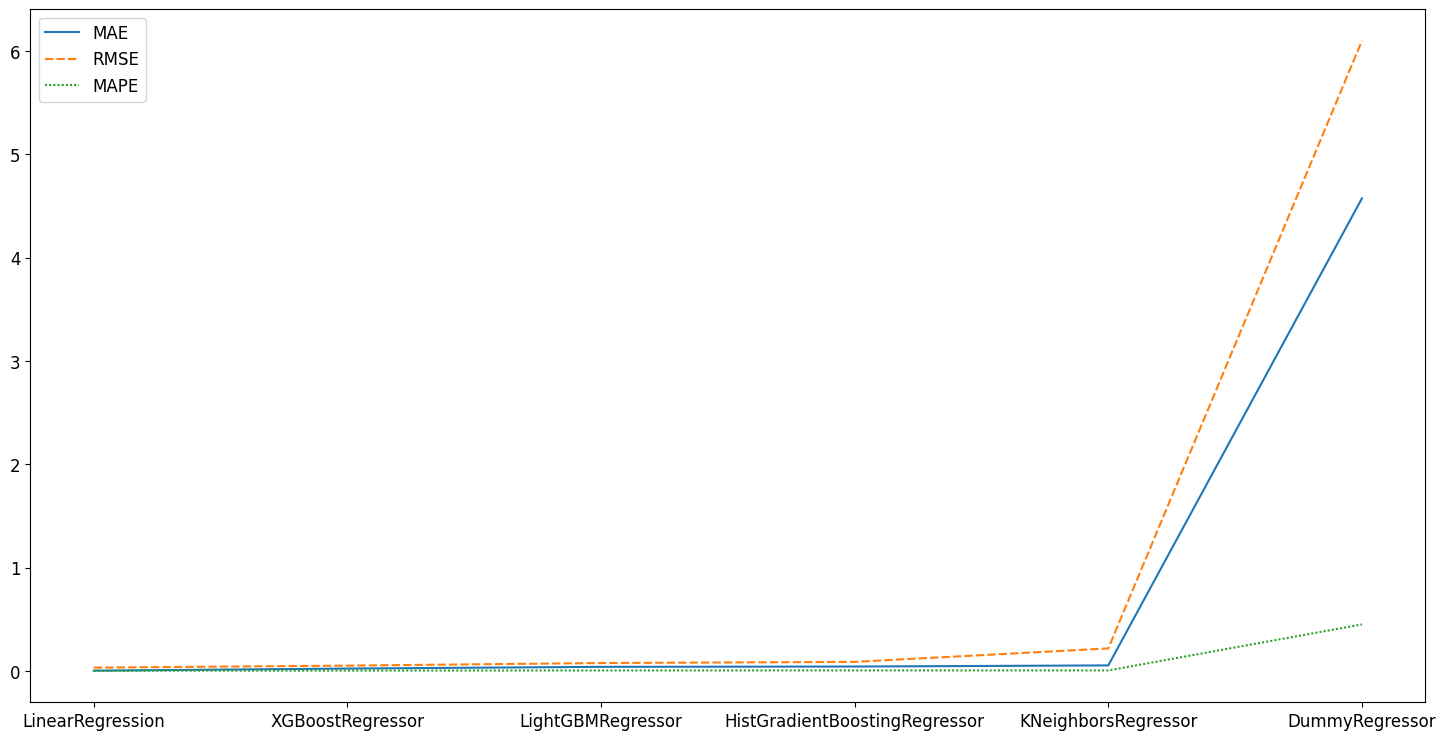

In [30]:
sns.lineplot(data=df_model_comparison)

# 7. Hyperparameters fine-tuning

mlflow server \
    --backend-store-uri sqlite:///backend.db \
    --default-artifact-root ./mlartifacts

In [14]:
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Experiment_01")

2023/03/05 18:13:25 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_01' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/sheep/documents/repos/predict-taxi-tip-amount/mlflow/mlartifacts/1', creation_time=1678050805356, experiment_id='1', last_update_time=1678050805356, lifecycle_stage='active', name='Experiment_01', tags={}>

## 7.1. Bayesian search

In [15]:
def objective(
    hyperparameters: Dict[str, Any],
    cv: Optional[int] = 10
) -> Dict[str, Any]:
    """Defines what should be achieved.
    Args:
        hyperparameters (dict[str, any]): Desired hyperparameters to try out.
        cv (int): Determines the cross-validation splitting strategy.
    Returns:
        Dictionary containing the loss value, its respective hyperparameters
            that were used, and an OK status.
    """
    used_data: List[str] = glob(os.path.join(DATA_DIR, "raw", "train", "*.dvc"))
    mlflow.set_tags({
        "developer": "Gabriel Cenciati",
        "release_candidate": "LightGBM Regressor",
        "used_training_data": used_data
    })
    with mlflow.start_run(
        run_name=f"Bayesian_Search_Fine_Tuning",
        nested=True
    ):
        regressor = LGBMRegressor(**hyperparameters)
        scores: List[float] = cross_validate(
            regressor,
            X_val.drop("id", axis=1).to_numpy(),
            y_val.to_numpy(),
            cv=cv,
            scoring=(
                "neg_mean_absolute_error",
                "neg_root_mean_squared_error",
                "neg_mean_absolute_percentage_error"
            ),
        )
        results: Dict[str, float] = get_metrics(scores)
        mlflow.lightgbm.log_model(
            regressor.fit(
                X_train.drop("id", axis=1).to_numpy(),
                y_train.to_numpy()
            ),
            ARTIFACT_DIR
        )
        mlflow.log_params(hyperparameters)
        mlflow.log_metrics(results)
        return {
            "loss": results["RMSE"],
            "hyperparameters": hyperparameters,
            "status": STATUS_OK
        }

In [16]:
search_space: Dict[str, int | float] = {
    "num_leaves": hp.choice("num_leaves", [4, 8, 16, 32, 64, 128]),
    "max_depth": hp.choice("max_depth", [-1, 10, 50, 100]),
    "n_estimators": hp.choice("n_estimators", [100, 250, 500, 1000, 1500]),
    "learning_rate": hp.choice("learning_rate", [0.001, 0.01, 0.1, 0.3]),
}
bayes_trials = Trials()
MAX_EVALS: int = 20

# Minimize objective function over the search space
best_hyperparameters: Dict[str, int | float] = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    trials=bayes_trials,
    max_evals=MAX_EVALS,
    verbose=False
)
print(best_hyperparameters)

[03/05/23 18:13:31] INFO     build_posterior_wrapper took 0.004307 seconds                               ]8;id=499748;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=375441;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 0 trials                                                          ]8;id=146039;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=295528;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:13:45] INFO     build_posterior_wrapper took 0.002315 seconds                               ]8;id=838234;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=262674;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 1/1 trials with best loss 0.068022                                ]8;id=631140;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=945989;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:14:08] INFO     build_posterior_wrapper took 0.001505 seconds                               ]8;id=77324;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=942500;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 2/2 trials with best loss 0.068022                                ]8;id=587007;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=105592;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:14:18] INFO     build_posterior_wrapper took 0.001219 seconds                               ]8;id=671532;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=957361;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 3/3 trials with best loss 0.068022                                ]8;id=907343;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=546678;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:14:23] INFO     build_posterior_wrapper took 0.001167 seconds                               ]8;id=575352;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=960489;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 4/4 trials with best loss 0.068022                                ]8;id=418196;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=744754;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:14:46] INFO     build_posterior_wrapper took 0.001820 seconds                               ]8;id=1198;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=641620;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 5/5 trials with best loss 0.068022                                ]8;id=255759;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=765752;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:12] INFO     build_posterior_wrapper took 0.001965 seconds                               ]8;id=200348;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=961564;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 6/6 trials with best loss 0.068022                                ]8;id=149416;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=842194;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:18] INFO     build_posterior_wrapper took 0.001233 seconds                               ]8;id=335601;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=917595;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 7/7 trials with best loss 0.068022                                ]8;id=316089;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=578045;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:28] INFO     build_posterior_wrapper took 0.001319 seconds                               ]8;id=348914;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=854030;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 8/8 trials with best loss 0.068022                                ]8;id=632485;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=573812;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:33] INFO     build_posterior_wrapper took 0.001483 seconds                               ]8;id=625252;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=836695;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 9/9 trials with best loss 0.068022                                ]8;id=304432;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=192800;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:37] INFO     build_posterior_wrapper took 0.001910 seconds                               ]8;id=642539;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=688557;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 10/10 trials with best loss 0.068022                              ]8;id=711693;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=794405;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:50] INFO     build_posterior_wrapper took 0.002065 seconds                               ]8;id=40518;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=883383;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 11/11 trials with best loss 0.068022                              ]8;id=869647;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=566860;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:15:58] INFO     build_posterior_wrapper took 0.001261 seconds                               ]8;id=550055;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=289023;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 12/12 trials with best loss 0.068022                              ]8;id=225654;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=938516;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:16:06] INFO     build_posterior_wrapper took 0.001147 seconds                               ]8;id=439797;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=607854;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 13/13 trials with best loss 0.068022                              ]8;id=672343;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=734239;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:16:40] INFO     build_posterior_wrapper took 0.001399 seconds                               ]8;id=340079;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=642549;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 14/14 trials with best loss 0.068022                              ]8;id=351556;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=886128;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:16:45] INFO     build_posterior_wrapper took 0.003974 seconds                               ]8;id=284203;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=122824;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 15/15 trials with best loss 0.068022                              ]8;id=178763;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=348689;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:16:53] INFO     build_posterior_wrapper took 0.001942 seconds                               ]8;id=821159;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=153467;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 16/16 trials with best loss 0.068022                              ]8;id=856812;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=601742;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:17:05] INFO     build_posterior_wrapper took 0.001380 seconds                               ]8;id=631421;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=713649;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 17/17 trials with best loss 0.067107                              ]8;id=197678;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=635791;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:17:14] INFO     build_posterior_wrapper took 0.001194 seconds                               ]8;id=95978;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=388119;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 18/18 trials with best loss 0.067107                              ]8;id=22687;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=204043;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/05/23 18:17:21] INFO     build_posterior_wrapper took 0.001167 seconds                               ]8;id=220805;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=762477;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 19/19 trials with best loss 0.067107                              ]8;id=23889;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=570672;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

{'learning_rate': 3, 'max_depth': 2, 'n_estimators': 3, 'num_leaves': 2}


## 7.2. Persist and evaluate tuned model

In [17]:
@dataclass(frozen=True)
class ModelRegistry:
    model_name: str
    model_version: str
    source: str
    run_id: str

In [18]:
class MlflowModelRegistry:
    """Simple wrapper for MLflow model registry functionality. It covers some handy functions
    that are not directly available yet in the native MLflow API."""

    def __init__(self, mlflow_client: MlflowClient, experiment_name: str) -> None:
        self.client = mlflow_client
        self.experiment_id: str = self.client.get_experiment_by_name(experiment_name).experiment_id

    def get_best_run_id(self, target_metric: str) -> str:
        return self.client.search_runs(
            experiment_ids=[self.experiment_id],
            order_by=[f"metrics.{target_metric} ASC"],
            max_results=1
        )[0].to_dictionary()["info"]["run_id"]

    def register_new_model_version(self, model_registry: ModelRegistry) -> None:
        try:
            self.client.create_registered_model(model_registry.model_name)
            self.client.create_model_version(
                name=model_registry.model_name,
                source=model_registry.source,
                run_id=model_registry.run_id
            )
            logger.info("Model %s has just been registred to %s at %s" % (
                model_registry.model_name,
                model_registry.source,
                datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            ))
        except MlflowException as exc:
            mlflow_error_message: str = "MLflow could not register this model."
            logger.critical(mlflow_error_message, exc)
            raise MlflowException(mlflow_error_message) from exc
        except Exception as exc:
            logger.critical("Model could not be registred.", exc)
            raise Exception from exc

    def get_all_registred_models(self) -> List[Dict[str, Any]]:
        return [dict(model) for model in self.client.search_registered_models()]

    def get_model_version_history(self, model_name: str) -> List[Dict[str, Any]]:
        return [dict(model) for model in self.client.search_model_versions(f"name='{model_name}'")]

In [19]:
mlflow_client = MlflowClient()
mlflow_model_registry = MlflowModelRegistry(mlflow_client, "Experiment_01")
best_run_id: str = mlflow_model_registry.get_best_run_id(target_metric="RMSE")
LGBM_REG_TUNED = ModelRegistry(
    model_name="lgbm-reg-tuned",
    model_version="1",
    source=f"runs:/{best_run_id}/{ARTIFACT_DIR}",
    run_id=best_run_id,
)

In [20]:
# Registry to MLflow models the best model we have,
# so we can version and use it
mlflow_model_registry.register_new_model_version(LGBM_REG_TUNED)
# Put best model into staging for testing phase
mlflow_client.transition_model_version_stage(
    name=LGBM_REG_TUNED.model_name,
    version=LGBM_REG_TUNED.model_version,
    stage="Staging",
    archive_existing_versions=False
)
mlflow_model_registry.get_all_registred_models()

2023/03/05 18:19:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lgbm-reg-tuned, version 1


[03/05/23 18:19:51] INFO     Model lgbm-reg-tuned has just been registred to                       ]8;id=231556;file:///tmp/ipykernel_22120/1502823609.py\1502823609.py]8;;\:]8;id=75467;file:///tmp/ipykernel_22120/1502823609.py#24\24]8;;\
                             runs:/a4b982f1d26444d49dcaa971ce06e8d1/models at 2023-03-05 18:19:51                  

[{'creation_timestamp': 1678051191290,
  'description': '',
  'last_updated_timestamp': 1678051191693,
  'latest_versions': [<ModelVersion: creation_timestamp=1678051191639, current_stage='Staging', description='', last_updated_timestamp=1678051191693, name='lgbm-reg-tuned', run_id='a4b982f1d26444d49dcaa971ce06e8d1', run_link='', source='runs:/a4b982f1d26444d49dcaa971ce06e8d1/models', status='READY', status_message='', tags={}, user_id='', version='1'>],
  'name': 'lgbm-reg-tuned',
  'tags': {}}]

In [36]:
# Test data must pass through the entire data pipeline so we can use it as input to the model
test_data: pd.DataFrame = pd.read_parquet(os.path.join(DATA_DIR, "raw", "test", "green_tripdata_2022-03.parquet"))
test_data["id"] = test_data.index + 1

class NYCTaxisPipelineExperiment01:
    def __init__(self, raw_data: pd.DataFrame) -> None:
        self.raw_data = raw_data

    def execute(self) -> pd.DataFrame:
        cleaned_data: pd.DataFrame = self.__clean_data(self.raw_data)
        cleaned_with_features_data: pd.DataFrame = self.__create_features(cleaned_data)
        return self.__preprocess_data(cleaned_with_features_data)

    def __clean_data(self, raw_data: pd.DataFrame) -> pd.DataFrame:
        raw_data.columns = [underscore(column) for column in raw_data.columns]
        raw_data.drop_duplicates(inplace=True)
        raw_data.dropna(subset=["payment_type", "trip_type"], axis=0, inplace=True)
        raw_data: pd.DataFrame = self.__treat_outliers(raw_data)    
        logger.info("Data cleansing completed.")
        return raw_data

    def __treat_outliers(self, raw_data_almost_cleaned: pd.DataFrame) -> pd.DataFrame:
        might_have_outlier_columns: List[str] = [
            "passenger_count", "trip_distance", "fare_amount",
            "extra", "mta_tax", "tip_amount", "tolls_amount",
            "improvement_surcharge", "total_amount", "congestion_surcharge"
        ]
        for column in might_have_outlier_columns:
            q75, q25 = np.percentile(raw_data_almost_cleaned.loc[:, column], 75), np.percentile(raw_data_almost_cleaned.loc[:, column], 25)
            iqr: float = q75 - q25
            cut_off: float = 3.0 * iqr
            lower, upper = q25 - cut_off, q75 + cut_off
            mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data_almost_cleaned.loc[:, column]]
            raw_data_almost_cleaned: pd.DataFrame = raw_data_almost_cleaned.loc[mask, :]
        return raw_data_almost_cleaned

    def __create_features(self, cleaned_data: pd.DataFrame) -> pd.DataFrame:
        cleaned_data["tax_per_meter"] = cleaned_data.loc[:, "trip_distance"] * cleaned_data.loc[:, "mta_tax"]
        cleaned_data["trip_duration"] = cleaned_data.loc[:, "lpep_dropoff_datetime"] - cleaned_data.loc[:, "lpep_pickup_datetime"]
        cleaned_data["trip_duration"] = cleaned_data["trip_duration"].dt.seconds / 60
        logger.info("Feature engineering completed.")
        return cleaned_data

    def __preprocess_data(self, cleaned_with_features_data: pd.DataFrame) -> pd.DataFrame:
        # Apply robust scaler
        for column in ["tip_amount", "extra"]:
            rs_preprocessor = joblib.load(os.path.join(PREPROCESSORS_DIR, "robust_scaler", f"{column}.joblib"))
            cleaned_with_features_data.loc[:, [column]] = rs_preprocessor.transform(cleaned_with_features_data.loc[:, [column]])
        # Apply standard scaler
        for column in ["fare_amount", "tax_per_meter", "trip_distance", "trip_duration"]:
            ss_preprocessor = joblib.load(os.path.join(PREPROCESSORS_DIR, "standard_scaler", f"{column}.joblib"))
            cleaned_with_features_data.loc[:, [column]] = ss_preprocessor.transform(cleaned_with_features_data.loc[:, [column]])
        # Apply one-hot encoding
        cleaned_with_features_data = pd.get_dummies(cleaned_with_features_data, columns=["payment_type"], drop_first=True)
        selected_columns: List[str] = [
            "id", "fare_amount", "trip_distance", "tax_per_meter",
            "trip_duration", "tip_amount", "extra", "payment_type_2.0",
            "total_amount"
        ]
        logger.info("Data preprocessing completed.")
        return cleaned_with_features_data.loc[:, selected_columns]

raw_test_data: pd.DataFrame = test_data.copy(deep=True)
pipeline = NYCTaxisPipelineExperiment01(raw_data=raw_test_data)
%time data: pd.DataFrame = pipeline.execute()
data.sample(3)

[03/05/23 18:30:04] INFO     Data cleansing completed.                                             ]8;id=533305;file:///tmp/ipykernel_22120/2893556341.py\2893556341.py]8;;\:]8;id=962080;file:///tmp/ipykernel_22120/2893556341.py#19\19]8;;\

                    INFO     Feature engineering completed.                                        ]8;id=689560;file:///tmp/ipykernel_22120/2893556341.py\2893556341.py]8;;\:]8;id=263121;file:///tmp/ipykernel_22120/2893556341.py#41\41]8;;\

                    INFO     Data preprocessing completed.                                         ]8;id=777597;file:///tmp/ipykernel_22120/2893556341.py\2893556341.py]8;;\:]8;id=82914;file:///tmp/ipykernel_22120/2893556341.py#60\60]8;;\

CPU times: user 337 ms, sys: 10.2 ms, total: 347 ms
Wall time: 367 ms


,id,fare_amount,trip_distance,tax_per_meter,trip_duration,tip_amount,extra,payment_type_2.0,total_amount
52403,52404,-0.793718,-0.761771,-0.761771,-0.140269,0.528524,2.0,0,7.30
58922,58923,-0.015316,0.693706,0.693706,-0.128138,0.528524,1.0,1,11.30
55246,55247,1.455000,1.380132,1.380132,0.125391,3.223045,0.0,0,23.16


In [38]:
model = mlflow.lightgbm.load_model(f"models:/{LGBM_REG_TUNED.model_name}/Staging")
X_test = data.drop("total_amount", axis=1)
y_test = data["total_amount"]
%time y_hat: np.ndarray = model.predict(X_test.drop("id", axis=1).to_numpy())
print({
    "results": [{
        "MAE": m.mean_absolute_error(y_test, y_hat),
        "RMSE": m.mean_squared_error(y_test, y_hat, squared=False),
        "MAPE": m.mean_absolute_percentage_error(y_test, y_hat)
    }],
    "prediction_date": datetime.now().strftime("%Y-%m-%d")
})

CPU times: user 1.84 s, sys: 10.2 ms, total: 1.85 s
Wall time: 481 ms
{'results': [{'MAE': 1.3286141387320864, 'RMSE': 1.7238542876310932, 'MAPE': 0.12533072881609236}], 'prediction_date': '2023-03-05'}


In [41]:
# Prepare final dataset to further analysis
joined_test_data: pd.DataFrame = pd.merge( # Dataframe containing only rows with predictions
    left=raw_test_data,
    right=X_test,
    on="id",
    how="inner",
    suffixes=["", "_x"]
)
joined_test_data = joined_test_data.loc[:, raw_test_data.columns] # Delete duplicated columns
joined_test_data["predictions"] = y_hat
joined_test_data.sample(15)

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,id,predictions
22149,2,2022-03-18 15:36:06,2022-03-18 15:51:06,N,1.0,244,152,1.0,2.20,11.5,0.0,0.5,2.46,0.0,None,0.3,14.76,1.0,1.0,0.0,39488,13.301436
15825,2,2022-03-13 14:52:19,2022-03-13 15:02:49,N,1.0,85,61,1.0,2.26,10.0,0.0,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.0,28276,11.299507
36170,2,2022-03-29 17:33:02,2022-03-29 17:46:22,N,1.0,244,166,1.0,2.95,12.5,1.0,0.5,1.00,0.0,None,0.3,15.30,1.0,1.0,0.0,64891,17.797675
20078,2,2022-03-17 06:04:09,2022-03-17 06:10:26,N,1.0,74,43,1.0,1.43,7.0,0.5,0.5,1.00,0.0,None,0.3,9.30,1.0,1.0,0.0,35907,10.353758
27408,2,2022-03-23 08:53:36,2022-03-23 08:56:47,N,1.0,75,74,1.0,0.73,4.5,0.0,0.5,1.59,0.0,None,0.3,6.89,1.0,1.0,0.0,49129,6.299179
16110,2,2022-03-13 18:43:21,2022-03-13 18:46:10,N,1.0,7,7,1.0,0.52,4.0,0.0,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.0,28802,5.303715
3624,2,2022-03-03 17:44:32,2022-03-03 18:12:57,N,1.0,43,244,1.0,5.79,22.0,1.0,0.5,5.95,0.0,None,0.3,29.75,1.0,1.0,0.0,6425,27.508804
38981,2,2022-03-31 19:38:33,2022-03-31 19:55:59,N,1.0,244,247,1.0,2.63,13.0,1.0,0.5,0.00,0.0,None,0.3,14.80,2.0,1.0,0.0,70051,18.385354
35089,2,2022-03-28 22:45:47,2022-03-28 22:57:30,N,1.0,106,89,1.0,2.62,11.0,0.5,0.5,0.00,0.0,None,0.3,12.30,2.0,1.0,0.0,62996,13.951281
29697,2,2022-03-24 17:31:52,2022-03-24 17:36:32,N,1.0,43,151,1.0,1.08,5.5,1.0,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.0,53222,10.967001


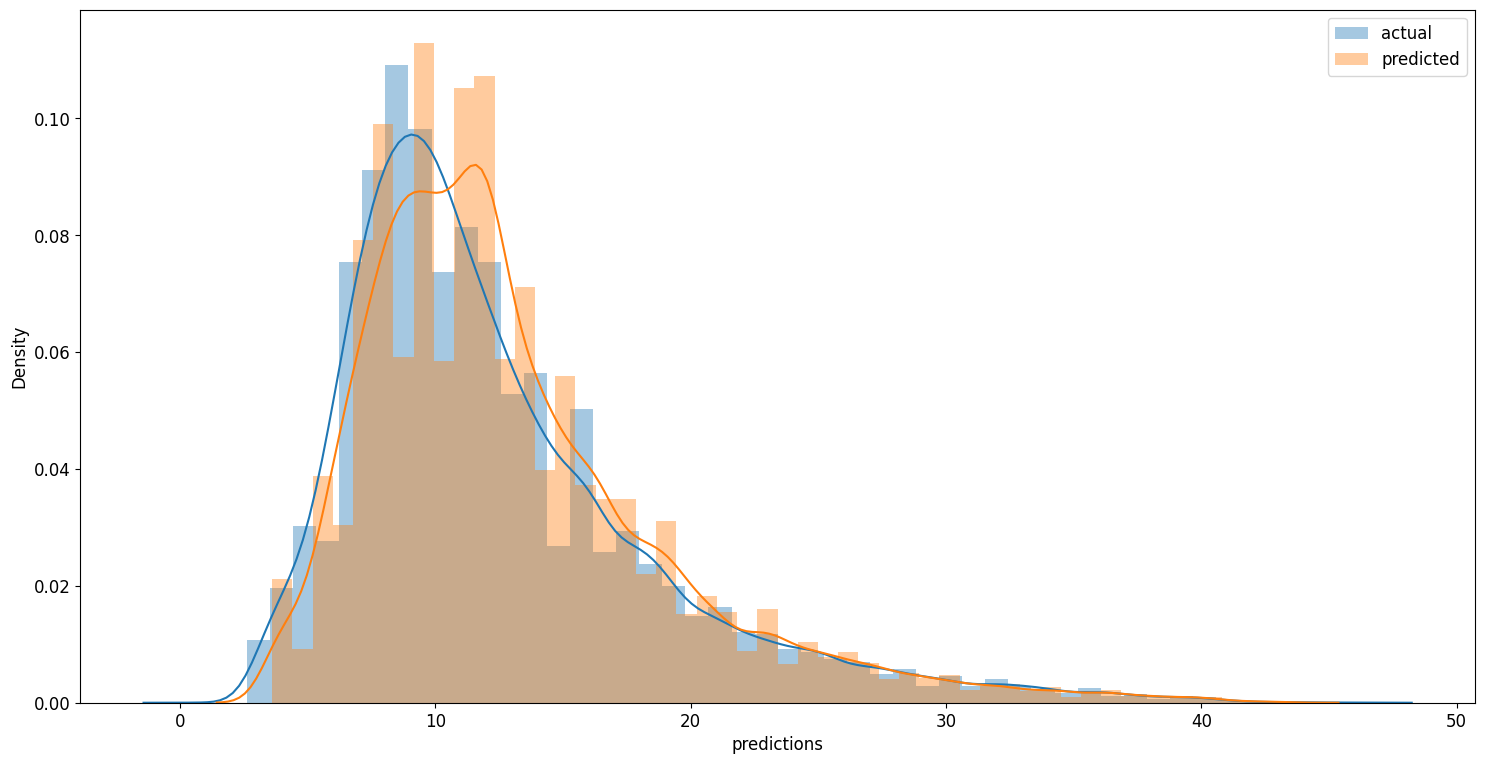

In [42]:
sns.distplot(joined_test_data["total_amount"], label="actual");
sns.distplot(joined_test_data["predictions"], label="predicted");
plt.legend();

In [43]:
# Since this model is the artifact of this notebook experiment,
# and its usage has just been tested and validated, now we can deploy this
# first version into production, and let it be handled by MLEngineers
# from now on.
mlflow_client.transition_model_version_stage(
    name=LGBM_REG_TUNED.model_name,
    version=LGBM_REG_TUNED.model_version,
    stage="Production",
    archive_existing_versions=True
)

<ModelVersion: creation_timestamp=1678051191639, current_stage='Production', description='', last_updated_timestamp=1678051892161, name='lgbm-reg-tuned', run_id='a4b982f1d26444d49dcaa971ce06e8d1', run_link='', source='runs:/a4b982f1d26444d49dcaa971ce06e8d1/models', status='READY', status_message='', tags={}, user_id='', version='1'>